In [2]:
import os
from google.colab import drive

drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Image_similarity')


os.listdir()


!pip install import_ipynb

import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np 
import os 
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator 
from keras.utils.np_utils import to_categorical
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
def plot_confusion_matrix(cm, classes,string,directory,normalize=False,title='Confusion matrix'):
    """
    Function which plots confusion matrix

    Input cm = confusion matrix
    Input classes = array with class labels
    Input string = string to give name of the saved image
    Input directory = string to give directory to save the image
    Input normalize (False) = If true function will give accuracy instead of pure number
    Input Title (Confusion matrix) = title of the image


    Output : None
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if(cm[i, j] > 0.8):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            continue

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    #plt.savefig(directory +'confusion_matrix'+string+'.jpg')

# GESTIONE DEL DATASET

Gestisco il dataset

In [4]:
lich_dic = {}
lich_name_dic = {}
for i,l in enumerate(os.listdir('../dataset/data/train')):
    lich_dic[l] = i
    lich_name_dic[i] = l



In [5]:
from skimage.filters import gaussian
def create_dataset(pth, lich_dic,train = True):
    licheni = os.listdir(pth)
    
    images = []
    labels = []
    for i,lich in enumerate(licheni):
        pt = os.path.join(pth, lich) 
        immagini_lichene = os.listdir(pt)
        for j, im in enumerate(immagini_lichene):

            if j > 600:
                continue
            img_pth = os.path.join(pt, im)
            img = cv2.imread(img_pth)
            img = cv2.resize(img, (100,100))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            images.append(img/255)
            labels.append(lich_dic[lich])
            if train == True:
                #perform data augmentation --> only rotation 80,180,270
                img90 = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
                img180 = cv2.rotate(img, cv2.ROTATE_180)
                img270 = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
                
                images.append(img90/255)
                images.append(img180/255)
                images.append(img270/255)


                labels.append(lich_dic[lich])
                labels.append(lich_dic[lich])
                labels.append(lich_dic[lich])




                img_gauss_1 = gaussian(img,sigma = 0.5)
                images.append(img_gauss_1)
                labels.append(lich_dic[lich])

                #if j == 0:
                 #   print(img_gauss_1)

                img_gauss_2 = gaussian(img,sigma = 1.0)
                images.append(img_gauss_2)
                labels.append(lich_dic[lich])

                img_gauss_3 = gaussian(img,sigma = 1.5)
                images.append(img_gauss_3)
                labels.append(lich_dic[lich])


                img_gauss_4 = gaussian(img,sigma = 2.0)
                images.append(img_gauss_4)
                labels.append(lich_dic[lich])






    
    images = np.array(images)
    labels = np.array(labels)
    images = images.reshape(-1,100,100,3).astype('float32') 
    labels = labels.astype('int')

    if train == True:
        images, labels = shuffle(images, labels)
        images = np.array(images)
        labels = np.array(labels)

    return images, labels


In [6]:
import cv2
train_data, train_lab = create_dataset('../dataset/data/train', lich_dic,train = True)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.


In [7]:
test_data, test_lab = create_dataset('../dataset/data/valid', lich_dic,train = False)
#train_lab.shape

In [8]:
train_groups = [train_data[np.where(train_lab==i)[0]] for i in np.unique(train_lab)]
test_groups = [test_data[np.where(test_lab==i)[0]] for i in np.unique(train_lab)]
print('train groups:', [x.shape[0] for x in train_groups])
print('test groups:', [x.shape[0] for x in test_groups])


train groups: [376, 344, 480, 576, 472, 480, 424, 464, 552, 408, 480, 480, 416, 440, 384, 480, 480, 384, 480, 432]
test groups: [28, 18, 20, 24, 20, 20, 24, 20, 23, 29, 20, 20, 28, 25, 16, 20, 20, 30, 20, 24]


In [9]:
total = []
for i in range(len(train_groups)):  
    total.append(train_groups[i].shape[0] + test_groups[i].shape[0])


print(total)

[404, 362, 500, 600, 492, 500, 448, 484, 575, 437, 500, 500, 444, 465, 400, 500, 500, 414, 500, 456]


##Batch Generation
Here the idea is to make usuable batches for training the network. We need to create parallel inputs for the  A  and  B  images where the output is the distance. Here we make the naive assumption that if images are in the same group the similarity is 1 otherwise it is 0.

If we randomly selected all of the images we would likely end up with most images in different groups.

In [10]:
def get_random_batch(in_groups,batch_halfsize = 8):  
    out_img_a, out_img_b, out_score, species = [], [], [], []
    all_groups = list(range(len(in_groups)))
    for match_group in [True, False]:
        group_idx = np.random.choice(all_groups, size = batch_halfsize)
        out_img_a += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in group_idx]
        if match_group:
            b_group_idx = group_idx
            out_score += [1]*batch_halfsize
        else:
            non_group_idx = [np.random.choice([i for i in all_groups if i!=c_idx]) for c_idx in group_idx]
            b_group_idx = non_group_idx
            out_score += [0]*batch_halfsize
        out_img_b += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in b_group_idx]
        # add species 
        for i in range(batch_halfsize):
            imageA_index = group_idx[i]
            imageB_index = b_group_idx[i]
            species.append([imageA_index, imageB_index])


    return np.stack(out_img_a,0), np.stack(out_img_b,0), np.stack(out_score,0), species

In [11]:
pv_a, pv_b, pv_sim,labels = get_random_batch(train_groups, 3)

In [12]:
pv_sim[0]

1

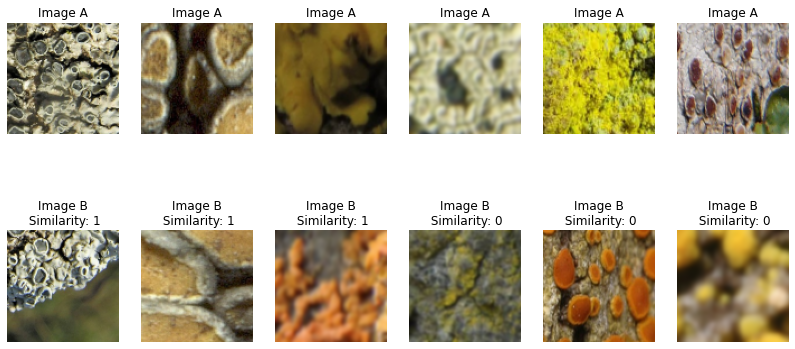

In [13]:
pv_a, pv_b, pv_sim, _ = get_random_batch(train_groups, 3)
fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize = (14, 7))
pv_sim = list(pv_sim)
for c_a, c_b, c_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, m_axs.T):

    ax1.imshow(c_a[:,:,:])
    ax1.set_title('Image A')
    ax1.axis('off')
    ax2.imshow(c_b[:,:,:])
    ax2.set_title('Image B\n Similarity: ' + str(c_d))
    ax2.axis('off')

# Feature Generation

Feature Generation
Here we make the feature generation network to process images into features. The network starts off randomly initialized and will be trained to generate useful vector features from input images (hopefully)

In [14]:
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, MaxPool2D, Activation, Flatten, Dense, Dropout

# Siamese Network 

We apply the feature generating model to both images and then combine them together to predict if they are similar or not. The model is designed to very simple. The ultimate idea is when a new image is taken that a feature vector can be calculated for it using the FeatureGenerationModel. All existing images have been pre-calculated and stored in a database of feature vectors. The model can be applied using a few vector additions and multiplications to determine the most similar images. These operations can be implemented as a stored procedure or similar task inside the database itself since they do not require an entire deep learning framework to run.

In [15]:
def show_model_output(dic_name_lich = lich_name_dic, nb_examples = 3):
    pv_a, pv_b, pv_sim,labs = get_random_batch(test_groups, nb_examples)
    pred_sim = similarity_model.predict([pv_a, pv_b])
    fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize = (20, 10))
    cont = 0
    for c_a, c_b, c_d, p_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, pred_sim, m_axs.T):
        ax1.imshow(c_a[:,:,:])
        ax1.set_title(dic_name_lich[labs[cont][0]] + '\n Actual: '+ str(c_d))
        ax1.axis('off')
        ax2.imshow(c_b[:,:,:])
        ax2.set_title(dic_name_lich[labs[cont][1]] +'\n Predicted: ' + str(p_d[0]))
        ax2.axis('off')
        cont = cont +1
    plt.savefig('results_KTH/model_output.jpg')
    return fig
# a completely untrained model
#_ = show_model_output()

In [16]:
# make a generator out of the data
def siam_gen(in_groups, batch_size = 64):
    while True:
        pv_a, pv_b, pv_sim,_ = get_random_batch(train_groups, batch_size//2)
        yield [pv_a, pv_b], pv_sim

In [17]:
def plot_and_save_image(running_corrects,val_running_corrects, running_loss,val_running_loss, title, direc):
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
    fig.suptitle(title)
    ax1.plot(running_corrects)
    ax1.plot(val_running_corrects)
    ax1.set_title('model mae')

    ax1.legend(['train', 'test'], loc='upper left')
    ax2.plot(running_loss)
    ax2.plot(val_running_loss)
    ax2.set_title('model loss')

    ax2.legend(['train', 'test'], loc='upper left')
    
    c = ['mae','loss']
    j = 0
    for ax in [ax1,ax2]:
        
        ax.set(xlabel='epochs', ylabel=c[j])
        j = j+1
    ax1.grid()
    ax2.grid()
    plt.savefig(direc)

In [18]:
def compute_test_accuracy_on_couples(model, num_ex, thresh ):
    acc = 0
    err = 0
    false_eq = 0
    false_div = 0
    pv_a, pv_b, pv_sim,labs = get_random_batch(test_groups,  num_ex)
    pred_sim = similarity_model.predict([pv_a, pv_b])
    for i in range(pred_sim.shape[0]):
        if i < num_ex:
            ass = pred_sim[i] > thresh
            if  ass[0]:
                acc = acc + 1               
            else:
                err = err + 1
                false_div = false_div + 1
        else:
            ass = pred_sim[i] <= thresh
            if ass[0]:
                acc = acc +1 
            else:
                err = err +1
                false_eq = false_eq + 1 
    res = acc /(num_ex*2)
    diverr = false_div/(num_ex*2)
    eqerr = false_eq /(num_ex*2) 
    res3 = err / (num_ex*2)    

    return pred_sim, labs , res, diverr,eqerr, res3







# MODO 1 

calcolo tra tutti i training set la similarità e poi prendo il più simile! 

In [19]:
def calculate_test_accuracy_on_image(train_data, train_lab, test_data, test_lab):
    #pass to all test data 
    acc = []
    test_data_num = test_data.shape[0]
    train_data_num = train_data.shape[0]
    for i in range(test_data_num):
        print('+++++ ',i,' +++++')
        similarity = []
        test = test_data[i]
        test = test.reshape([-1,100,100,3])
        # pass through all the training set and we calculate the similarity
        for j in range(train_data_num):

            trainx = train_data[j]
            trainx = trainx.reshape([-1,100,100,3])
            calc = similarity_model.predict([trainx,test])
            similarity.append(calc[0][0])
        print('predicting')
        pred = np.argmax(similarity)
        class_pred = train_lab[pred]
        if class_pred == test_lab[i]:
            acc.append(1)
        else:
            acc.append(0)
          

    return acc



# protonet- siamese net

In [20]:
img_in = Input(shape = train_data.shape[1:], name = 'FeatureNet_ImageInput')
n_layer_proto = img_in 
for i in range(4):
    n_layer_proto = Conv2D(64, kernel_size = (3,3), activation = 'linear')(n_layer_proto)
    n_layer_proto = BatchNormalization()(n_layer_proto)
    n_layer_proto = Activation('relu')(n_layer_proto)
    n_layer_proto = MaxPool2D((2,2))(n_layer_proto)


n_layer_proto = Dropout(0.5)(n_layer_proto)
n_layer_proto = Flatten()(n_layer_proto)
n_layer_proto = Dense(32, activation = 'linear')(n_layer_proto)
n_layer_proto = Dropout(0.5)(n_layer_proto)
n_layer_proto = BatchNormalization()(n_layer_proto)
n_layer_proto = Activation('relu')(n_layer_proto)
feature_model = Model(inputs = [img_in], outputs = [n_layer_proto], name = 'FeatureGenerationModel')
feature_model.summary()
                               


Model: "FeatureGenerationModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
FeatureNet_ImageInput (Input [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 98, 98, 64)        1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 98, 98, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 98, 98, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 47, 47, 

In [21]:
from keras.layers import concatenate
from keras.layers import Subtract
from keras.initializers import RandomNormal
img_a_in = Input(shape = train_data.shape[1:], name = 'ImageA_Input')
img_b_in = Input(shape = train_data.shape[1:], name = 'ImageB_Input')
img_a_feat = feature_model(img_a_in)
img_b_feat = feature_model(img_b_in)
b_init = RandomNormal(mean = 0.5, stddev = 1e-2)

#subtracted = Subtract()([img_a_feat, img_b_feat])
#prediction = Dense(1, activation='sigmoid', bias_initializer=b_init)(subtracted)
#siamese_net = Model(inputs=[img_a_in, img_b_in], outputs=prediction)
combined_features = concatenate([img_a_feat, img_b_feat], name = 'merge_features')
combined_features = Dense(16, activation = 'linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(4, activation = 'linear')(combined_features)
#combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(1, activation = 'sigmoid')(combined_features)
similarity_model = Model(inputs = [img_a_in, img_b_in], outputs = [combined_features], name = 'Similarity_Model')
similarity_model.summary()

Model: "Similarity_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ImageA_Input (InputLayer)       [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
ImageB_Input (InputLayer)       [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
FeatureGenerationModel (Functio (None, 32)           146528      ImageA_Input[0][0]               
                                                                 ImageB_Input[0][0]               
__________________________________________________________________________________________________
merge_features (Concatenate)    (None, 64)           0           FeatureGenerationM

In [22]:
# setup the optimization process
similarity_model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['mae'])

In [23]:
valid_a, valid_b, valid_sim,_ = get_random_batch(test_groups, 1024)

In [24]:
loss_history = similarity_model.fit_generator(siam_gen(train_groups),steps_per_epoch=500,
                                              validation_data = ([valid_a, valid_b], valid_sim), epochs = 50, 
                                                            verbose = True)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
500/500 [==============================] - 79s 90ms/step - loss: 0.7008 - mae: 0.4953 - val_loss: 0.6121 - val_mae: 0.4258
Epoch 2/50
500/500 [==============================] - 44s 89ms/step - loss: 0.6094 - mae: 0.4330 - val_loss: 0.5762 - val_mae: 0.3746
Epoch 3/50
500/500 [==============================] - 44s 89ms/step - loss: 0.5631 - mae: 0.3914 - val_loss: 0.5573 - val_mae: 0.3695
Epoch 4/50
500/500 [==============================] - 44s 89ms/step - loss: 0.5380 - mae: 0.3695 - val_loss: 0.5638 - val_mae: 0.3658
Epoch 5/50
500/500 [==============================] - 44s 89ms/step - loss: 0.5220 - mae: 0.3586 - val_loss: 0.5758 - val_mae: 0.3711
Epoch 6/50
500/500 [==============================] - 45s 89ms/step - loss: 0.5019 - mae: 0.3419 - val_loss: 0.5457 - val_mae: 0.3282
Epoch 7/50
500/500 [==============================] - 45s 89ms/step - loss: 0.4954 - mae: 0.3369 - val_loss: 0.5768 - val_mae: 0.3351
Epoch 8/50
500/500 [==============================] - 45s 89ms

In [25]:
acc = loss_history.history['mae']
val_acc = loss_history.history['val_mae']
loss = loss_history.history['loss']
val_loss = loss_history.history['val_loss']

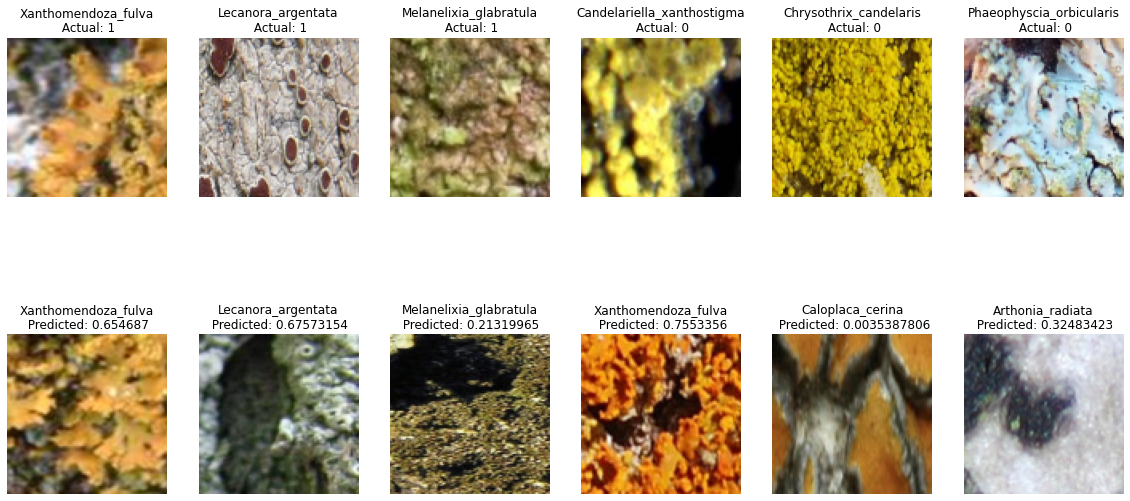

In [26]:
_ = show_model_output(nb_examples =  3)

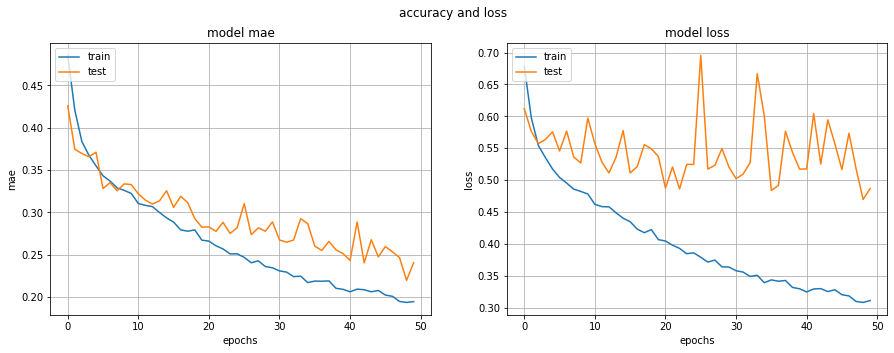

In [27]:
plot_and_save_image(acc,val_acc,loss,val_loss,'accuracy and loss ','results/acc_loss.jpg')

In [ ]:
from sklearn.metrics import roc_curve, auc

def prediction(similarity_model, num_ex,th):
    y_pred = np.zeros(2*num_ex)
    pv_a, pv_b, pv_sim,labs = get_random_batch(test_groups,  num_ex)
    pred_sim = similarity_model.predict([pv_a, pv_b])
    for i in range(pred_sim.shape[0]):
        if pred_sim[i] > th:
            y_pred[i] = 1
        else:
            y_pred[i] = 0
    return y_pred 




def plot_roc_curve(model, num_ex):
    true_pos_rate = []
    false_pos_rate = []
    y_true = np.zeros(2*num_ex)
    for i in range(num_ex):
      y_true[i] = 1
    threshold = list(np.arange(0,1.01,0.01))
    pv_a, pv_b, pv_sim,labs = get_random_batch(test_groups,  num_ex)
    pred_sim = similarity_model.predict([pv_a, pv_b])

    fpr, tpr, thresholds = roc_curve(y_true, pred_sim)
    auc_logistic = auc(fpr, tpr)
    gmeans = np.sqrt(tpr * (1-fpr))
    ix = np.argmax(gmeans)
    print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
    #print(logistic_fpr)
    #print(logistic_tpr)
    plt.figure(figsize=(5, 5), dpi=100)
    plt.plot(fpr, tpr, marker='.', label='ROC (auc = %0.3f)' % auc_logistic)
    plt.plot(np.arange(0,1.01,0.01),np.arange(0,1.01,0.01))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.grid()
    plt.legend()
    print(auc_logistic)
    return thresholds



thr = plot_roc_curve(similarity_model,10000)



In [41]:
threshold = np.arange(1.01,0,-0.01)
print(threshold.shape)

(101,)


In [ ]:
threshold = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

tot_error = []
tot_fe = []
tot_fd = []
tot_acc = []
for j in range(1):
  acc = []
  fe = []
  fd = []
  error = []
  for th in threshold:
      print('---')
      _,_,res,diverr, eqerr, err = compute_test_accuracy_on_couples(similarity_model, 100,th)
      acc.append(res)
      fe.append(eqerr)
      fd.append(diverr)
      error.append(err)
  tot_acc.append(acc)
  tot_fn.append(fn)
  tot_fp.append(fp)
  tot_error.append(error)


acc = np.mean(tot_acc,axis = 0)
fn = np.mean(tot_fn,axis= 0)
fp = np.mean(tot_fp, axis = 0)
error = np.mean(tot_error, axis = 0)
print(acc)

---
---
---
---
---
---
---
---
---
[0.81  0.78  0.77  0.82  0.81  0.785 0.775 0.805 0.54 ]


In [ ]:
print(acc)

[0.81  0.78  0.77  0.82  0.81  0.785 0.775 0.805 0.54 ]


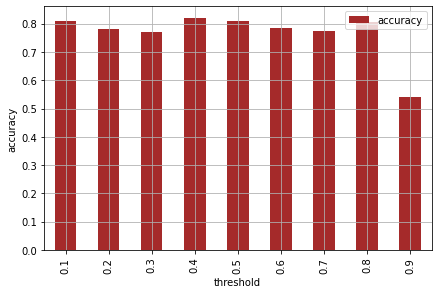

In [ ]:
import pandas as pd
df = pd.DataFrame({"":threshold, "accuracy":acc})
df.plot(x="", y=["accuracy"], kind="bar", color = 'brown')
plt.tight_layout()
plt.xlabel('threshold')
plt.ylabel('accuracy')
plt.grid()

In [ ]:
print(fe)
print(fd)
print(error)

[0.14, 0.15, 0.11, 0.1, 0.095, 0.125, 0.085, 0.055, 0.015]
[0.05, 0.07, 0.12, 0.08, 0.095, 0.09, 0.14, 0.14, 0.445]
[0.19  0.22  0.23  0.18  0.19  0.215 0.225 0.195 0.46 ]


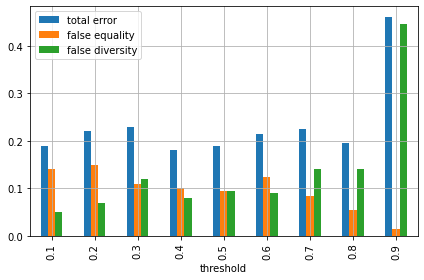

In [ ]:
x1 = [200,250,300,350,400,450,500,550,600,650,700,750,800,850,900]
df = pd.DataFrame({"X":threshold, "total error":error,"false equality":fe,'false diversity': fd})
df.plot(x="X", y=["total error", "false equality",'false diversity'], kind="bar")
plt.grid()
plt.xlabel('threshold')
plt.ylabel('')
plt.tight_layout()

In [ ]:
def extact_images_spec_lichen(test_groups, test_lab, lich_index):
    res = []
    number_test = test_lab.shape[0]
    for i in range(number_test):
        if test_lab[i] == lich_index:
            temp = test_groups[i]
            res.append(temp)
        else:
            continue 
    res = np.array(res)
    res = res.reshape(-1,100,100,3).astype('float32') 
    return res
              


def calculate_mean_affinity(similarity_model, test_groups, test_lab, lich1, lich2):
    data_lich1 = extact_images_spec_lichen(test_groups, test_lab, lich1)
    data_lich2 = extact_images_spec_lichen(test_groups, test_lab, lich2)
    res = []
    for i in range(data_lich1.shape[0]):
        for j in range(i,data_lich2.shape[0]):
          im1 = data_lich1[i]
          im2 = data_lich2[j]
          im1 = im1.reshape([-1,100,100,3])
          im2 = im2.reshape([-1,100,100,3])
          affinity = similarity_model.predict([im1, im2])
          #print(affinity[0])
          res.append(affinity[0])
    
    res = np.array(affinity)
    return res, np.mean(res)

In [ ]:
def classify_image(test_groups, test_labels, img_ind, similarity_model):
    sim = []
    image = test_groups[img_ind]
    image = image.reshape([-1,100,100,3])
    image_lab = test_labels[img_ind] 
    for i in range(test_groups.shape[0]):
        if i == img_ind:
            sim.append(-1)
            continue 
        else:
            im2 = test_groups[i]
            im2 = im2.reshape([-1,100,100,3])
            aff = similarity_model.predict([image, im2])
            sim.append(aff)
    sim = np.array(sim)

    maximo = np.argmax(sim)
    classe = test_labels[maximo]
    return classe,sim

In [ ]:

affinity = np.zeros((20,20))

for i in range(20):
    print(i)
    for j in range(i,20):
        _,mean = calculate_mean_affinity(similarity_model, test_data, test_lab,i,j)
        affinity[i,j] = mean
        affinity[j,i] = mean


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


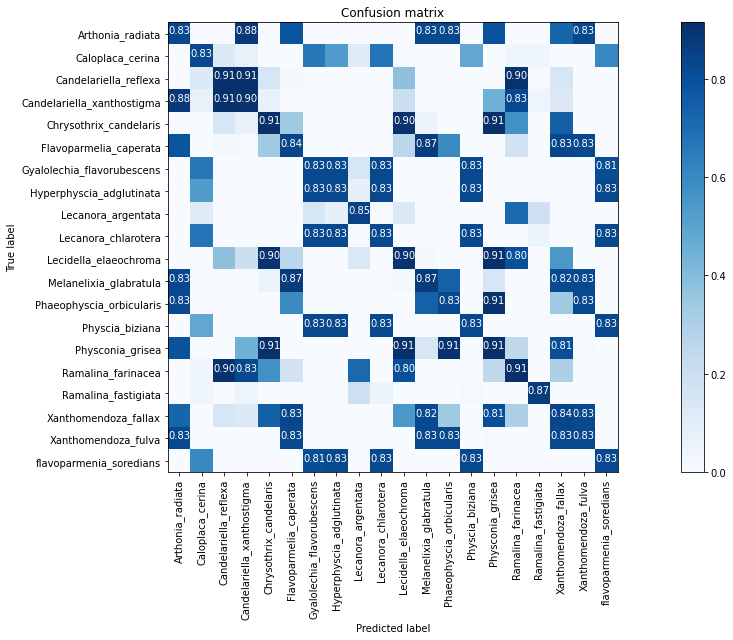

In [ ]:
species = ['Arthonia_radiata','Caloplaca_cerina','Candelariella_reflexa','Candelariella_xanthostigma','Chrysothrix_candelaris','Flavoparmelia_caperata','Gyalolechia_flavorubescens','Hyperphyscia_adglutinata'
        ,'Lecanora_argentata','Lecanora_chlarotera','Lecidella_elaeochroma','Melanelixia_glabratula'
        ,'Phaeophyscia_orbicularis','Physcia_biziana','Physconia_grisea','Ramalina_farinacea','Ramalina_fastigiata','Xanthomendoza_fallax','Xanthomendoza_fulva','flavoparmenia_soredians']
import matplotlib.pyplot as plt
import itertools
plt.figure(figsize = (18,9))
plot_confusion_matrix(affinity,species,'','',normalize=False)

In [ ]:
def plot_confusion_matrix(cm, classes,string,directory,normalize=False,title='Confusion matrix'):
    """
    Function which plots confusion matrix

    Input cm = confusion matrix
    Input classes = array with class labels
    Input string = string to give name of the saved image
    Input directory = string to give directory to save the image
    Input normalize (False) = If true function will give accuracy instead of pure number
    Input Title (Confusion matrix) = title of the image


    Output : None
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if(cm[i, j] > -1.0 or i == j):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            continue

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    #plt.savefig(directory +'confusion_matrix'+string+'.jpg')



# Few-shot classification with training data

In [ ]:
from numpy import random

def choose_training_data(train_groups, number_of_samples):
    lab = []
    train_set = []
    for i in range(len(train_groups)):
        temporary_set = []
        images = train_groups[i]
        # extract random numbers array 
        lista_index = np.arange(images.shape[0])
        random.shuffle(lista_index)
        for j in range(number_of_samples):
            img = images[lista_index[j]]
            lab.append(i)
            temporary_set.append(img)
        
        temporary_set = np.array(temporary_set)
        temporary_set = temporary_set.reshape(-1,100,100,3).astype('float32') 
        train_set.append(temporary_set)
    lab = np.array(lab)
    lab = lab.astype('int')
    return train_set, lab

In [ ]:
train10 ,lab = choose_training_data(train_groups, 10)

In [ ]:
def mean_affinity(temp_group, test, model):
    dist = []
    test = test.reshape([-1,100,100,3])
    for i in range(temp_group.shape[0]):
        tmp = temp_group[i]
        tmp = tmp.reshape([-1,100,100,3])
        aff = similarity_model.predict([tmp, test])
        dist.append(aff)
    dist = np.array(dist)
    return np.mean(dist)
        


In [ ]:
def calculate_20_way_10_shot_accuracy(train10, test_data, test_lab, model):
    accuracy_1 = 0
    accuracy_2 = 0
    for i in range(test_data.shape[0]):
        print(i)
        test = test_data[i]
        mean_distances = []
        # viaggio all'interno delle distanza
        for j in range(len(train10)):
            temp_group = train10[j]
            dst = mean_affinity(temp_group, test, model)
            mean_distances.append(dst)

        maximo = np.argmax(mean_distances)
        print(mean_distances) 
        new_mean_distances = []
        for ii in range(len(mean_distances)):
            if ii == maximo:
                new_mean_distances.append(-1)
            else:
                new_mean_distances.append(mean_distances[ii])
        maximo_2 = np.argmax(new_mean_distances)
        #mean_distances.sort(reverse = True)
        


        print('-------')
        if maximo == test_lab[i]:
            accuracy_1 = accuracy_1 + 1
        elif maximo_2 == test_lab[i]: 
            accuracy_2 = accuracy_2 + 1
          
          
        
    
    return accuracy_1 / test_data.shape[0], accuracy_2 / test_data.shape[0]

            

In [ ]:
c = [1,2,35,5]
c[2] = -1
c

In [ ]:
acc1,acc2 = calculate_20_way_10_shot_accuracy(train_groups, test_data, test_lab, similarity_model)

# 5-way 10-shot problem

In this last part of notebook we will try to use our

In [ ]:
from numpy import random
few_lich_dic = {}
few_lich_name_dic = {}
for i,l in enumerate(os.listdir('../dataset/few_shot/few_shot_train')):
    few_lich_dic[l] = i
    few_lich_name_dic[i] = l


In [ ]:
few_lich_dic

{'Amandinea_punctata': 4,
 'Candelaria_concolor': 1,
 'Lecanora_carpinea': 0,
 'Melanelixia_subaurifera': 2,
 'Xanthoria_parietina': 3}

In [ ]:
names = ['Lecanora carpinea', 'Candelaria concolor', 'Melanelixia subaurifera', 'Xanthoria Parietina','Amandinea Punctata']

In [ ]:
import cv2
train_data, train_lab = create_dataset('../dataset/few_shot/few_shot_train', lich_dic,train = False)
print('inizio test')
test_data, test_lab = create_dataset('../dataset/few_shot/few_shot_test', lich_dic,train = False)

inizio test


In [ ]:
train_groups = [train_data[np.where(train_lab==i)[0]] for i in np.unique(train_lab)]
test_groups = [test_data[np.where(test_lab==i)[0]] for i in np.unique(train_lab)]
print('train groups:', [x.shape[0] for x in train_groups])
print('test groups:', [x.shape[0] for x in test_groups])


train groups: [10, 10, 10, 10, 10]
test groups: [38, 61, 22, 38, 49]


Text(0.5, 0, 'Xanthoria Parietina')

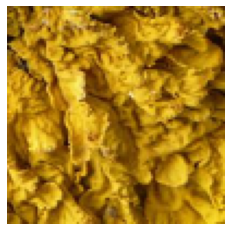

In [ ]:
import matplotlib.pyplot as plt
classe = 3
immagine = 0
test_image = test_groups[classe][immagine]
tst = test_image
test_image = test_image.reshape([-1,100,100,3])
plt.imshow(tst)
plt.axis('off')
plt.xlabel(names[3])


In [ ]:
classe = 3
immagine = 0
test_image = test_groups[classe][immagine]
test_image = test_image.reshape([-1,100,100,3])
similarity_score = []
# viaggio tra le classi
for i in range(len(train_groups)):
    print(i)
    lichen = train_groups[i]
    temp_score_similarity = []
    for j in range(len(lichen)):
        tmp = lichen[j]
        tmp = tmp.reshape([-1,100,100,3])
        aff = similarity_model.predict([tmp, test_image])
        temp_score_similarity.append(aff)
    temp_score_similarity = np.array(temp_score_similarity)
    similarity_score.append(aff[0][0])


print(similarity_score)

0
1
2
3
4
[4.3489536e-07, 0.8370078, 0.83370125, 0.89649683, 1.7218743e-05]


In [ ]:
similarity_score
print(np.argmax(similarity_score))

3


<Figure size 1296x360 with 0 Axes>

<Figure size 1296x360 with 0 Axes>

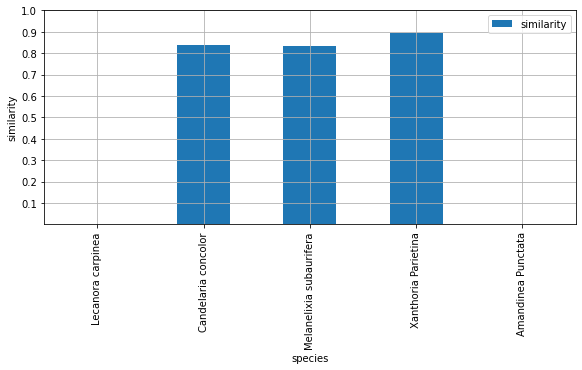

In [ ]:
import pandas as pd
plt.figure(figsize=(18, 5))
df = pd.DataFrame({"":names, "similarity":similarity_score})
plt.figure(figsize=(18, 5))
df.plot(x="", y=["similarity"], kind="bar", figsize = (8,5 ))
plt.tight_layout()
plt.xlabel('species')
plt.ylabel('similarity')
plt.yticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
plt.grid()

In [ ]:
# compute confusion matrix and mean accuracy 
media_classi = []
confusion_matrix = np.zeros((5,5))
similarity_matrix = np.zeros((5,5))
for cl in range(5):
  
    print('---------------------', cl)
    test_images = test_groups[cl]
    for i in range(len(test_images)):
        print(i)
        img = test_images[i]
        img = img.reshape([-1,100,100,3])
        mean_sim = []
        for ii in range(5):
            mean_sim_tmp = []
            comp_group = train_groups[ii]
            for j in range(len(comp_group)):
                tmp = comp_group[j]
                tmp = tmp.reshape([-1,100,100,3])
                aff = similarity_model.predict([tmp, img])
                mean_sim_tmp.append(aff[0][0])
            mean_sim_tmp = np.array(mean_sim_tmp)
            mean_sim.append(np.mean(mean_sim_tmp))
        print('mean_sim ',mean_sim)
        classe_predetta = np.argmax(mean_sim)
        print('---> ',cl,'  ',classe_predetta)
        confusion_matrix[cl,classe_predetta] = confusion_matrix[cl,classe_predetta] + 1
        if classe_predetta == cl:
            media_classi.append(1)
        else:
            media_classi.append(0)


In [ ]:
confusion_matrix

array([[24.,  0.,  0.,  0., 14.],
       [ 4.,  0.,  8., 49.,  0.],
       [ 2.,  2.,  3., 15.,  0.],
       [ 0.,  0.,  1., 37.,  0.],
       [27.,  0.,  1.,  0., 21.]])

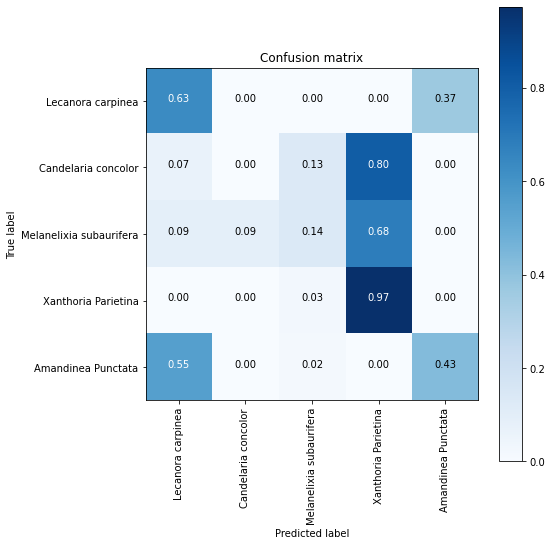

In [ ]:
import itertools
plt.figure(figsize = (8,8))
plot_confusion_matrix(confusion_matrix, names,'','',title='similarity matrix',normalize = True)

In [ ]:
affinity = np.zeros((5,5))

for i in range(5):
    print('-----')
    print(i)
    test_images = test_groups[i]
    for j in range(i,5):
        print(j)
        temporary = []
        train_images = train_groups[j]
        for ii in range(len(test_images)):
            
            immagine = test_images[ii]
            immagine = immagine.reshape([-1,100,100,3])
            for jj in range(len(train_images)):
                if ii == jj and i==j:
                    continue 
                tmp = train_images[jj]
                tmp= tmp.reshape([-1,100,100,3])
                aff = similarity_model.predict([tmp, immagine])
                temporary.append(aff[0][0])
        temporary = np.array(temporary)
        affinity[i,j] = np.mean(temporary)
        affinity[j,i] = np.mean(temporary)
            



-----
0
0
1
2
3
4
-----
1
1
2
3
4
-----
2
2
3
4
-----
3
3
4
-----
4
4


In [ ]:
affinity

array([[4.71338600e-01, 2.60307657e-04, 5.60409613e-02, 1.52596222e-05,
        4.32872564e-01],
       [2.60307657e-04, 6.33206606e-01, 6.33826137e-01, 7.43943989e-01,
        2.60419305e-02],
       [5.60409613e-02, 6.33826137e-01, 6.71094596e-01, 7.03083098e-01,
        5.71941584e-02],
       [1.52596222e-05, 7.43943989e-01, 7.03083098e-01, 8.80110145e-01,
        1.39793602e-03],
       [4.32872564e-01, 2.60419305e-02, 5.71941584e-02, 1.39793602e-03,
        4.41464305e-01]])

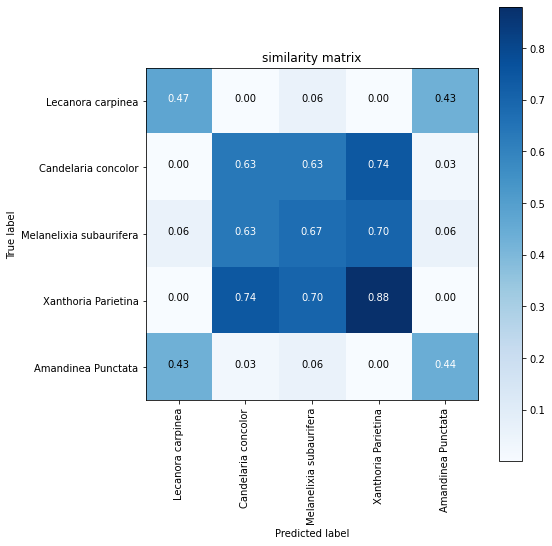

In [ ]:
plt.figure(figsize = (8,8))
plot_confusion_matrix(affinity ,names,'','',title='similarity matrix',normalize = False)